In [1]:
# Если что-то меняется в коде, мы хотим это сразу видеть здесь
%load_ext autoreload
%autoreload 2

In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

from tabulate import tabulate
from tqdm.notebook import tqdm

from itertools import product, chain
from collections import namedtuple
import time
import numpy as np
import pandas as pd

# Подключаем локальные пакеты
from pyqumo.random import Distribution, Exponential, HyperExponential, Erlang
from pyqumo.cqumo.sim import simulate_tandem

# Поключаем пакеты для ML
import math
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns


from pyqumo.fitting.johnson89 import fit_mern2
from pyqumo.stats import get_std, get_cv, get_skewness, get_noncentral_m2, get_noncentral_m3
from pyqumo.random import HyperErlang

In [2]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

In [9]:
# Нужно ли пересчитывать все, или можно использовать результаты из файлов
FORCE_SIMULATION = False
# SIM_FILE_NAME = '01_tandem_simulation.csv'
SIM_FILE_NAME = '03_tandem_simulation_with_influence_of_3rd_moment.csv'
SIM_FILE_DIR = 'data'
SIM_FILE_PATH = os.path.join(SIM_FILE_DIR, SIM_FILE_NAME)

# Зададим число пакетов, передачу которых по сети мы будем моделировать.
# Чем выше это число, тем точнее результаты, но на их получение нужно больше времени.
NUM_PACKETS = 1000000

# Цветовая схема для графиков
CMAP_NAME = 'viridis'

## Вызов имитационной модели, чтение и сохранение результатов

Определим полезные функции, которые нам потребуются для работы с данными имитационного моделирования:

- `load_sim_data()`: читает файл `SIM_FILE_NAME`, если он существует, или создает новый `DataFrame` для хранения данных о результатах имитационного моделирования.
- `save_sim_data()`: сохраняет результаты, записанные в `DataFrame`, в файл `SIM_FILE_PATH`.

In [31]:
COLUMNS = (
    'ArrM1',
    'ArrM2',
    'ArrM3',
    'ArrAvg', 
    'ArrStd', 
    'ArrCv',
    'ArrSkewness',
    'SrvM1',
    'SrvM2',
    'SrvM3',
    'SrvAvg', 
    'SrvStd', 
    'SrvCv',
    'SrvSkewness', 
    'Rho', 
    'NetSize', 
    'Capacity', 
    'NumPackets',
    'DelayAvg', 
    'DelayStd', 
    'DeliveryProb',
)

In [32]:
def simulate(
    df: pd.DataFrame, *,
    arr_m1: float,
    arr_m2: float,
    arr_m3: float,
    srv_m1: float,
    srv_m2: float,
    srv_m3: float,
    net_size: int,
    capacity: int,
    num_packets: int,
    force: bool = False
) -> pd.DataFrame:
    """
    Выполнить симуляцию, если результатов нет в `df` или требуется их пересчитать, и вернуть новый `DataFrame`.
    """
    row_df = df[
        (df.ArrM1 == arr_m1) &
        (df.ArrM2 == arr_m2) &
        (df.ArrM3 == arr_m3) &
        (df.ArrAvg == arr_m1) &
        (df.ArrM2 == arr_m2) &
        (df.ArrM3 == arr_m3) &
        (df.SrvM1 == srv_m1) &
        (df.SrvM2 == srv_m2) &
        (df.SrvM3 == srv_m3) &
        (df.NetSize == net_size) &
        (df.Capacity == capacity)]
    
    # Вычислим признаки, которые говорят о необходимости пересчета:
    no_row = len(row_df) == 0
    not_enough_packets = (not no_row) and (row_df.NumPackets.iloc[0] < num_packets)

    # Проверим, нужно ли пересчитать результаты:
    if force or no_row or not_enough_packets:
        arr,_  = fit_mern2(moments=[arr_m1, arr_m2, arr_m3], strict=False)
        srv,_ = fit_mern2(moments=[srv_m1, srv_m2, srv_m3], strict=False)
        ret = simulate_tandem(arr, [srv] * net_size, capacity, num_packets)

        row_data = {
            'ArrM1': arr_m1,
            'ArrM2': arr_m2,
            'ArrM3': arr_m3,
            'ArrAvg': arr_m1,
            'ArrStd': get_std(arr_m1, arr_m2),
            'ArrCv': get_cv(arr_m1, arr_m2),
            'ArrSkewness': get_skewness(arr_m1, arr_m2, arr_m3),
            'SrvM1': srv_m1,
            'SrvM2': srv_m2,
            'SrvM3': srv_m3,
            'SrvAvg': srv_m1,
            'SrvStd': get_std(srv_m1, srv_m2),
            'SrvCv': get_cv(srv_m1, srv_m2),
            'SrvSkewness': get_skewness(srv_m1, srv_m2, srv_m3),
            'Rho': srv_m1 / arr_m1,
            'NetSize': net_size,
            'Capacity': capacity,
            'NumPackets': num_packets,
            'DelayAvg': ret.delivery_delays[0].avg,
            'DelayStd': ret.delivery_delays[0].std,
            'DeliveryProb': ret.delivery_prob[0],
        }
        # Если строки еще вообще не было, добавляем ее, а если была - обновляем:
        if no_row:
            df = df.append(row_data, ignore_index=True)
        else:
            df.update(pd.DataFrame(row_data, index=[row_df.index[0]]))

    return df

In [21]:
def get_m2(m1: float, cv:float) -> float:
    """Compute the 2nd moment.
    """
    return (m1 * cv) ** 2 + m1 ** 2 


def get_m3(m1: float, m2: float, skewness:float) -> float:
    """Compute the 3rd moment.
    """
    var = m2 - m1**2
    std = var**0.5
    return var * std * skewness + 3*m1*var - m1**3

In [36]:
POINTS_NUMBER = 20
ARR_CV = [0.5, 0.8, 1, 2, 3]
ARR_M1 = [1] * len(ARR_CV) * POINTS_NUMBER
ARR_SKEWNESS = []

for i in range(len(ARR_CV)):
    skewnes_min = ARR_CV[i] - 1/ARR_CV[i]
    step = 5
    skewness_max = ARR_CV[i] - 1/ARR_CV[i] + POINTS_NUMBER*step
    ARR_SKEWNESS += list(np.linspace(skewnes_min, POINTS_NUMBER*step, POINTS_NUMBER))

ARR_CV = [[i] * POINTS_NUMBER for i in ARR_CV]
ARR_CV = list(chain(*ARR_CV))

ARR_M2 = [get_m2(arr_m1, cv) for cv, arr_m1 in zip(ARR_CV, ARR_M1)]
ARR_M3 = [get_m3(ARR_M1[i], ARR_M2[i], ARR_SKEWNESS[i]) for i in range(len(ARR_CV))]

SRV_M1 = [1] * len(ARR_CV)
SRV_M2 = [9] * len(ARR_CV)
SRV_M3 = [10000] * len(ARR_CV)
NET_SIZE = [1] * len(ARR_CV)
CAPACITY = [6] * len(ARR_CV)

check_arr_skewness_data = pd.DataFrame(columns=COLUMNS)
# Выполним симуляцию:
for i in tqdm(range(len(ARR_CV))):
    check_arr_skewness_data = simulate(
        check_arr_skewness_data,
        arr_m1=ARR_M1[i],
        arr_m2=ARR_M2[i],
        arr_m3=ARR_M3[i],
        srv_m1=SRV_M1[i],
        srv_m2=SRV_M2[i],
        srv_m3=SRV_M3[i],
        net_size=NET_SIZE[i],
        capacity=CAPACITY[i],
        num_packets=NUM_PACKETS,
        force=FORCE_SIMULATION
    )


  0%|          | 0/100 [00:00<?, ?it/s]

previous gamma:  -17.5
new gamma:  -1.1999999999999993
previous gamma:  -12.157894736842106
new gamma:  -1.1999999999999993
previous gamma:  -6.815789473684211
new gamma:  -1.1999999999999993
previous gamma:  -4.356249999999998
new gamma:  -0.36
previous gamma:  -2.0
new gamma:  2.0
previous gamma:  1.25
new gamma:  1.7999999999999998
previous gamma:  2.5925925925925926
new gamma:  3.1999999999999997


In [37]:
check_arr_skewness_data

,ArrM1,ArrM2,ArrM3,ArrAvg,ArrStd,ArrCv,ArrSkewness,SrvM1,SrvM2,SrvM3,...,SrvStd,SrvCv,SrvSkewness,Rho,NetSize,Capacity,NumPackets,DelayAvg,DelayStd,DeliveryProb
0,1.0,1.25,-0.437500,1.0,0.5,0.5,-17.500000,1.0,9.0,10000.0,...,2.828427,2.828427,440.836884,1.0,1.0,6.0,1000000.0,3.908343,10.198562,0.910585
1,1.0,1.25,0.230263,1.0,0.5,0.5,-12.157895,1.0,9.0,10000.0,...,2.828427,2.828427,440.836884,1.0,1.0,6.0,1000000.0,3.899751,5.932522,0.914797
2,1.0,1.25,0.898026,1.0,0.5,0.5,-6.815789,1.0,9.0,10000.0,...,2.828427,2.828427,440.836884,1.0,1.0,6.0,1000000.0,3.889121,8.137913,0.913165
3,1.0,1.25,1.565789,1.0,0.5,0.5,-1.473684,1.0,9.0,10000.0,...,2.828427,2.828427,440.836884,1.0,1.0,6.0,1000000.0,3.891860,8.927866,0.912887
4,1.0,1.25,2.233553,1.0,0.5,0.5,3.868421,1.0,9.0,10000.0,...,2.828427,2.828427,440.836884,1.0,1.0,6.0,1000000.0,3.955467,8.535569,0.914187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,10.00,2172.736842,1.0,3.0,3.0,79.434698,1.0,9.0,10000.0,...,2.828427,2.828427,440.836884,1.0,1.0,6.0,1000000.0,4.200197,10.649652,0.849065
96,1.0,10.00,2311.052632,1.0,3.0,3.0,84.557505,1.0,9.0,10000.0,...,2.828427,2.828427,440.836884,1.0,1.0,6.0,1000000.0,4.166896,9.066658,0.852886
97,1.0,10.00,2449.368421,1.0,3.0,3.0,89.680312,1.0,9.0,10000.0,...,2.828427,2.828427,440.836884,1.0,1.0,6.0,1000000.0,4.131340,6.422768,0.856974
98,1.0,10.00,2587.684211,1.0,3.0,3.0,94.803119,1.0,9.0,10000.0,...,2.828427,2.828427,440.836884,1.0,1.0,6.0,1000000.0,4.171965,8.875373,0.853031


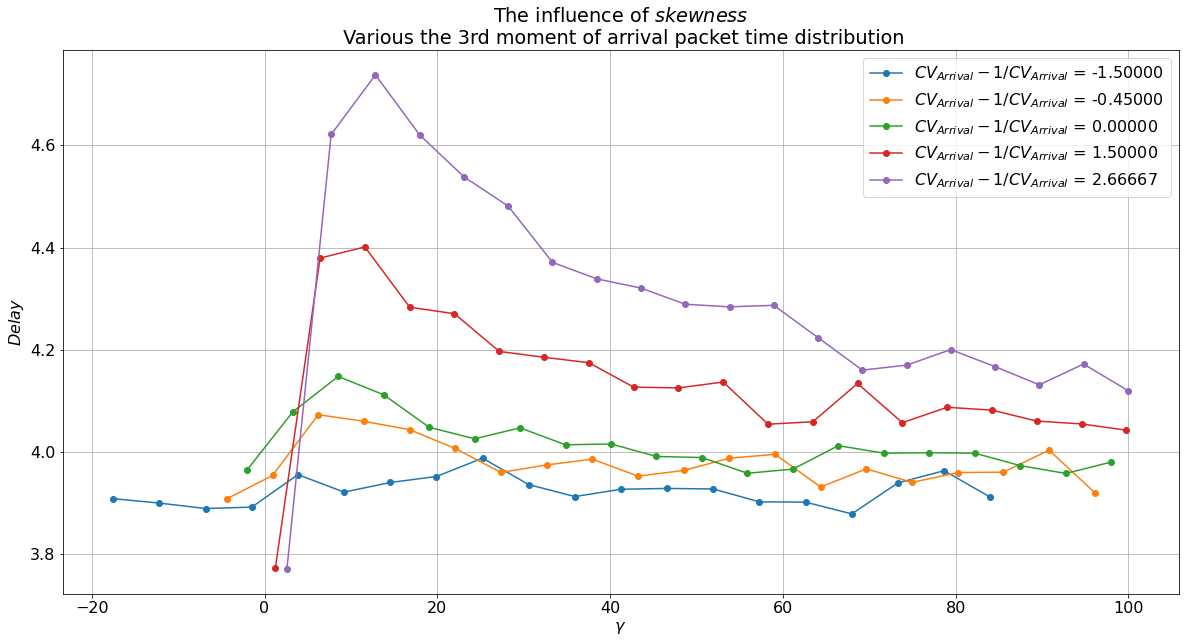

In [47]:
plt.figure(figsize=(20, 10))
plt.title('The influence of $skewness$ \n Various the 3rd moment of arrival packet time distribution')
for i in check_arr_skewness_data['ArrCv'].unique():
    data = check_arr_skewness_data[check_arr_skewness_data['ArrCv'] == i]
     
    # coef_var = [(cv - 1/cv) for cv in data['ArrCv']]
    plt.plot(data['ArrSkewness'], data['DelayAvg'], '-o', 
             label='$CV_{Arrival} - 1/ CV_{Arrival}$ = ' + str('{:.5f}'.format(i - 1/i)))


plt.legend()
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$Delay$')
plt.grid()

In [45]:
POINTS_NUMBER = 20
SRV_CV = [0.5, 0.8, 1, 2, 3]
SRV_M1 = [1] * len(SRV_CV) * POINTS_NUMBER
SRV_SKEWNESS = []

for i in range(len(SRV_CV)):
    skewnes_min = SRV_CV[i] - 1/SRV_CV[i]
    step = 5
    skewness_max = SRV_CV[i] - 1/SRV_CV[i] + POINTS_NUMBER*step
    SRV_SKEWNESS += list(np.linspace(skewnes_min, POINTS_NUMBER*step, POINTS_NUMBER))

SRV_CV = [[i] * POINTS_NUMBER for i in SRV_CV]
SRV_CV = list(chain(*SRV_CV))
SRV_M2 = [get_m2(srv_m1, cv) for cv, srv_m1 in zip(SRV_CV, SRV_M1)]
SRV_M3 = [get_m3(SRV_M1[i], SRV_M2[i], SRV_SKEWNESS[i]) for i in range(len(SRV_CV))]

ARR_M1 = [1] * len(SRV_CV)
ARR_M2 = [9] * len(SRV_CV)
ARR_M3 = [10000] * len(SRV_CV)
NET_SIZE = [1] * len(SRV_CV)
CAPACITY = [6] * len(SRV_CV)

check_srv_skewness_data = load_sim_data()
# Выполним симуляцию:
for i in tqdm(range(len(ARR_CV))):
    check_srv_skewness_data = simulate(
        check_srv_skewness_data,
        arr_m1=ARR_M1[i],
        arr_m2=ARR_M2[i],
        arr_m3=ARR_M3[i],
        srv_m1=SRV_M1[i],
        srv_m2=SRV_M2[i],
        srv_m3=SRV_M3[i],
        net_size=NET_SIZE[i],
        capacity=CAPACITY[i],
        num_packets=NUM_PACKETS,
        force=FORCE_SIMULATION
    )


  0%|          | 0/100 [00:00<?, ?it/s]

previous gamma:  -17.5
new gamma:  -1.1999999999999993
previous gamma:  -12.157894736842106
new gamma:  -1.1999999999999993
previous gamma:  -6.815789473684211
new gamma:  -1.1999999999999993
previous gamma:  -4.356249999999998
new gamma:  -0.36
previous gamma:  -2.0
new gamma:  2.0
previous gamma:  1.25
new gamma:  1.7999999999999998
previous gamma:  2.5925925925925926
new gamma:  3.1999999999999997


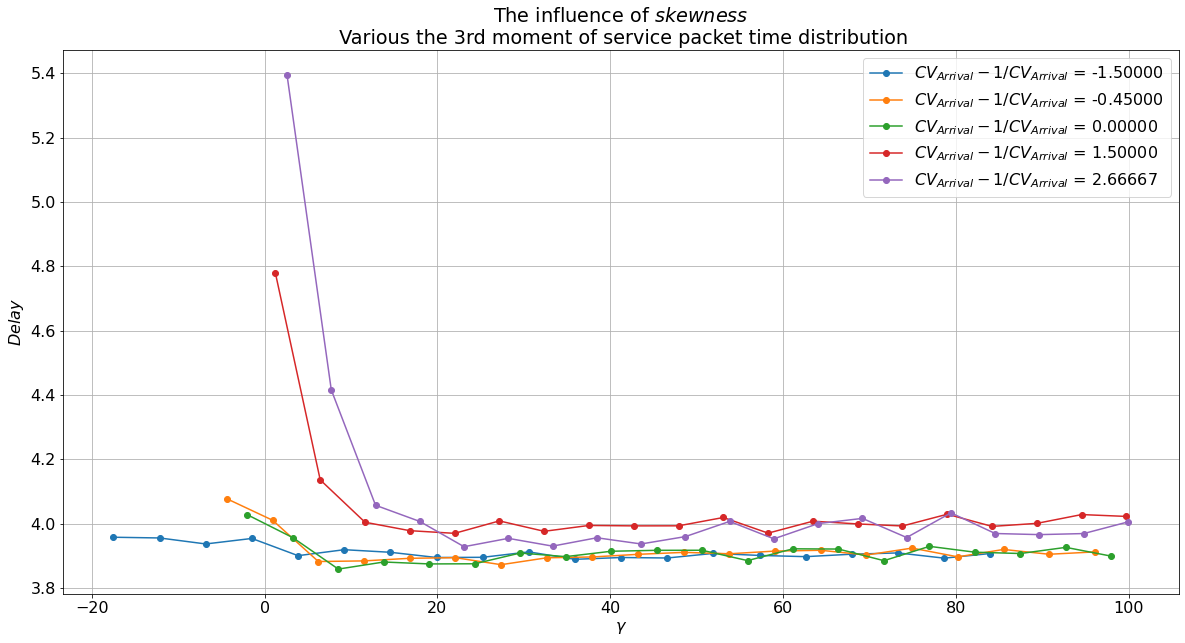

In [51]:
plt.figure(figsize=(20, 10))
plt.title('The influence of $skewness$ \n Various the 3rd moment of service packet time distribution')
for i in check_srv_skewness_data['SrvCv'].unique():
    data = check_srv_skewness_data[check_srv_skewness_data['SrvCv'] == i]
     
    # coef_var = [(cv - 1/cv) for cv in data['ArrCv']]
    plt.plot(data['SrvSkewness'], data['DelayAvg'], '-o', 
             label='$CV_{Arrival} - 1/ CV_{Arrival}$ = ' + str('{:.5f}'.format(i - 1/i)))


plt.legend()
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$Delay$')
plt.grid()

In [50]:
check_srv_skewness_data

,ArrM1,ArrM2,ArrM3,ArrAvg,ArrStd,ArrCv,ArrSkewness,SrvM1,SrvM2,SrvM3,...,SrvStd,SrvCv,SrvSkewness,Rho,NetSize,Capacity,NumPackets,DelayAvg,DelayStd,DeliveryProb
0,1.0,9.0,10000.0,1.0,2.828427,2.828427,440.836884,1.0,1.25,-0.437500,...,0.5,0.5,-17.500000,1.0,1.0,6.0,1000000.0,3.958340,2.083511,0.907745
1,1.0,9.0,10000.0,1.0,2.828427,2.828427,440.836884,1.0,1.25,0.230263,...,0.5,0.5,-12.157895,1.0,1.0,6.0,1000000.0,3.956100,2.085719,0.907966
2,1.0,9.0,10000.0,1.0,2.828427,2.828427,440.836884,1.0,1.25,0.898026,...,0.5,0.5,-6.815789,1.0,1.0,6.0,1000000.0,3.937459,2.083336,0.908671
3,1.0,9.0,10000.0,1.0,2.828427,2.828427,440.836884,1.0,1.25,1.565789,...,0.5,0.5,-1.473684,1.0,1.0,6.0,1000000.0,3.954569,2.083143,0.907720
4,1.0,9.0,10000.0,1.0,2.828427,2.828427,440.836884,1.0,1.25,2.233553,...,0.5,0.5,3.868421,1.0,1.0,6.0,1000000.0,3.901066,2.130693,0.910364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,9.0,10000.0,1.0,2.828427,2.828427,440.836884,1.0,10.00,2172.736842,...,3.0,3.0,79.434698,1.0,1.0,6.0,1000000.0,4.034109,7.807125,0.853591
96,1.0,9.0,10000.0,1.0,2.828427,2.828427,440.836884,1.0,10.00,2311.052632,...,3.0,3.0,84.557505,1.0,1.0,6.0,1000000.0,3.969929,7.541517,0.859696
97,1.0,9.0,10000.0,1.0,2.828427,2.828427,440.836884,1.0,10.00,2449.368421,...,3.0,3.0,89.680312,1.0,1.0,6.0,1000000.0,3.966463,7.595340,0.861382
98,1.0,9.0,10000.0,1.0,2.828427,2.828427,440.836884,1.0,10.00,2587.684211,...,3.0,3.0,94.803119,1.0,1.0,6.0,1000000.0,3.969765,7.783617,0.861766
